# Summary

Derive all the equations of GME theory (where possible), using SymPy, for a given erosion model type ($\sin\beta$ or $\tan\beta$), slope exponent $\eta \in \left\{\tfrac{1}{4}, \tfrac{1}{3}, \tfrac{1}{2}, \tfrac{3}{2}\right\}$, and ratio of area/slope exponent $\mu/\eta$ (usually set to 1/2).

### Preliminaries

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['Derivation_sinbeta_eta1p5_ratio0p5']
#     pr_filenames = ['Derivation_sinbeta_eta0p5_ratio0p5']
#     pr_filenames = ['Derivation_sinbeta_eta0p33_ratio1p0']
#     pr_filenames = ['Derivation_sinbeta_eta0p25_ratio1p0']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])
    
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import Rational, simplify, factor, Matrix, Eq, \
                    solve, sin, cos, tan, atan, Abs, sqrt, re, im, N, \
                    numer, denom, expand, Piecewise, lambdify, deg
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['Derivation_sinbeta_eta1p5_ratio0p5'])

In [2]:
parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'derivation',
    'subtitle': '',
    'title': 'Derivation of GME equations for sin(beta) erosion model, '
             'eta=3/2, mu=3/4',
    'verbose': True,
    'very_verbose': False}
{   'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 3/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 3/4,
    't_xiv0_list': None,
    'varepsilon': 1/100,
    'varphi_0': 300,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.01,
    'vb_res': 101}
{   'do_eliminate_caustics': Tru

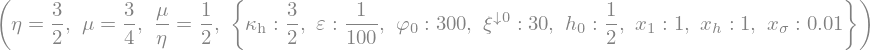

In [3]:
sub = {
        x_1: pr.model.x_1, 
        varepsilon: pr.model.varepsilon, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0,
        kappa_h: pr.model.kappa_h,
        h_0: pr.model.h_0,
        x_sigma: pr.model.x_sigma,
        x_h: pr.model.x_h
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Equations

## Basics

In [4]:
gmeq = Equations( eta=pr.model.eta, mu=pr.model.mu,
                  beta_type=pr.model.beta_type, varphi_type=pr.model.varphi_type, 
                  do_raw=True, do_nothing=True )

In [5]:
def eqns(eqn_list):
    return [getattr(gmeq, eqn) for eqn in eqn_list]

## Vector $\mathbf{{r}}$

In [6]:
gmeq.define_r_eqns()

In [7]:
eqns(['rx_r_alpha_eqn', 'rz_r_alpha_eqn'])

## Covector $\mathbf{\widetilde{p}}$

In [8]:
gmeq.define_p_eqns()

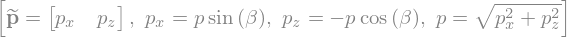

In [9]:
eqns(['p_covec_eqn', 'px_p_beta_eqn', 'pz_p_beta_eqn', 'p_norm_pxpz_eqn'])

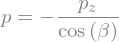

In [10]:
gmeq.p_pz_cosbeta_eqn

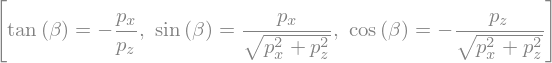

In [11]:
eqns(['tanbeta_pxpz_eqn', 'sinbeta_pxpz_eqn', 'cosbeta_pxpz_eqn'])

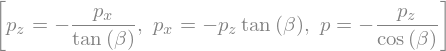

In [12]:
eqns(['pz_px_tanbeta_eqn', 'px_pz_tanbeta_eqn', 'p_pz_cosbeta_eqn'])

## Erosion model

### $\xi$ model

In [13]:
gmeq.define_xi_eqns()

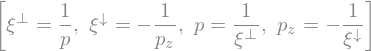

In [14]:
eqns(['xi_p_eqn', 'xiv_pz_eqn', 'p_xi_eqn', 'pz_xiv_eqn'])

In [15]:
gmeq.define_xi_model_eqn()

In [16]:
eqns(['xi_varphi_beta_eqn'])

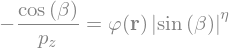

In [17]:
gmeq.xi_varphi_beta_eqn.subs(e2d(gmeq.xi_p_eqn)).subs(e2d(gmeq.p_pz_cosbeta_eqn))

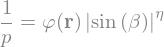

In [18]:
gmeq.xi_varphi_beta_eqn.subs(e2d(gmeq.xi_p_eqn))

### $\xi$ related eqns

In [19]:
gmeq.define_xi_related_eqns()

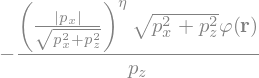

In [20]:
( (gmeq.xi_varphi_beta_eqn.rhs/cos(beta))
    .subs(e2d(gmeq.tanbeta_pxpz_eqn))
    .subs(e2d(gmeq.cosbeta_pxpz_eqn))
    .subs(e2d(gmeq.sinbeta_pxpz_eqn))
    .subs({(-Abs(px)/pz)**eta:px**eta/(-pz)**eta})
)

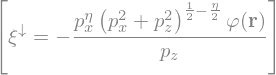

In [21]:
eqns(['xiv_varphi_pxpz_eqn'])

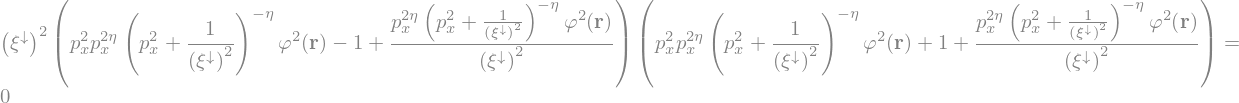

In [22]:
gmeq.px_xiv_varphi_eqn

### $\varphi$ model

In [23]:
gmeq.define_varphi_model_eqn()
gmeq.varphi_type

'ramp'

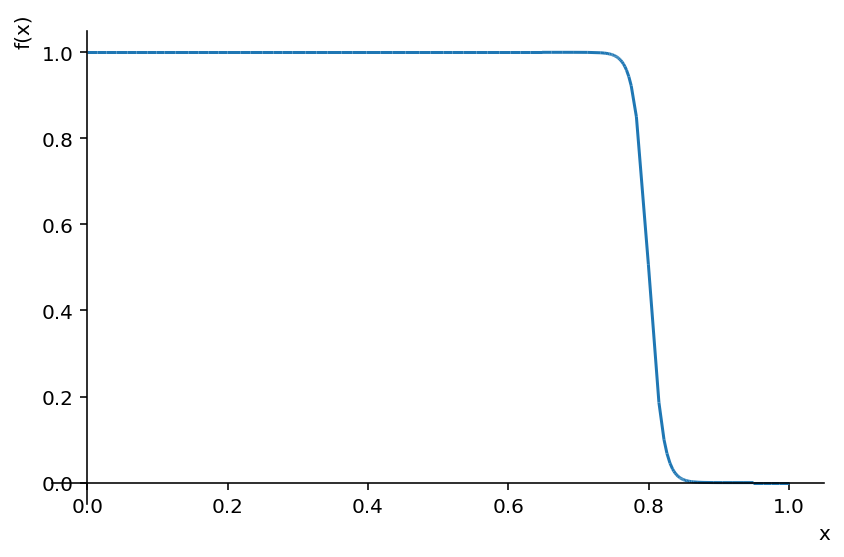

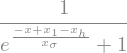

In [24]:
smooth_step_fn = 1/(1+sy.exp(((x_1-x_h)-x)/x_sigma))
sy.plot(smooth_step_fn.subs({x:x_1-x}).subs({x_sigma:0.01, x_h:0.8, x_1:1}), (x,0,1));
simplify(smooth_step_fn)

In [25]:
sub = {x_sigma:0.01, chi:30, x_h:0.8, x_1:1, varphi_0:1, mu:2}

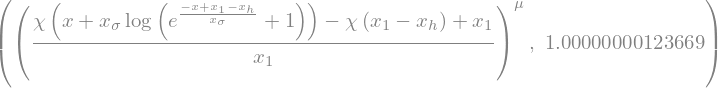

In [26]:
smooth_break_fn = simplify( ((chi/(x_1))*(sy.integrate(smooth_step_fn,x))-chi*(1-x_h/x_1)+1)**mu )
smooth_break_fn, smooth_break_fn.subs({x:x_1-rx}).subs({rx:x_1}).subs(sub)

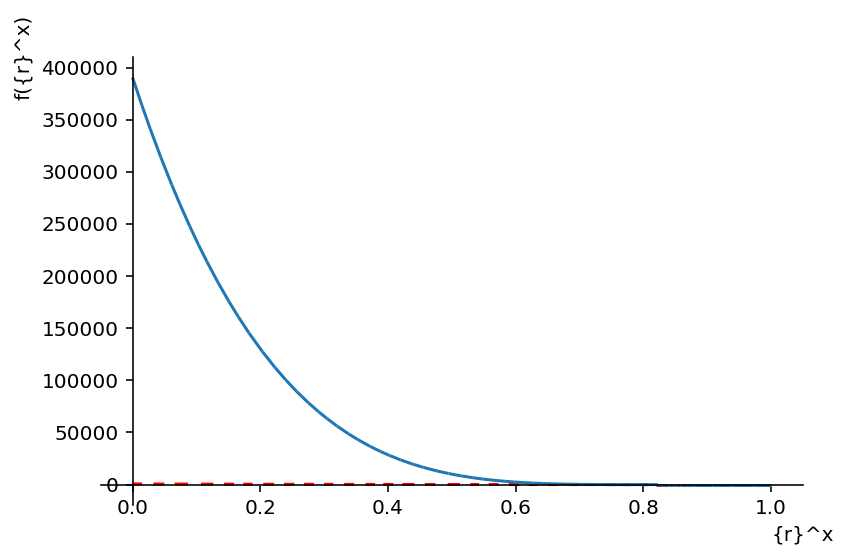

In [27]:
p=sy.plot(smooth_break_fn.subs({x:x_1-rx}).subs(sub),
          gmeq.varphi_model_rampflatmu_eqn.rhs.subs(sub), 
          (rx,0,1), show=False);
p[0].line_color = ['red','white']
p.show()

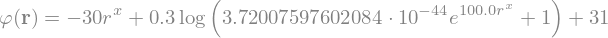

In [28]:
gmeq.varphi_model_rampflat_eqn.subs(sub)

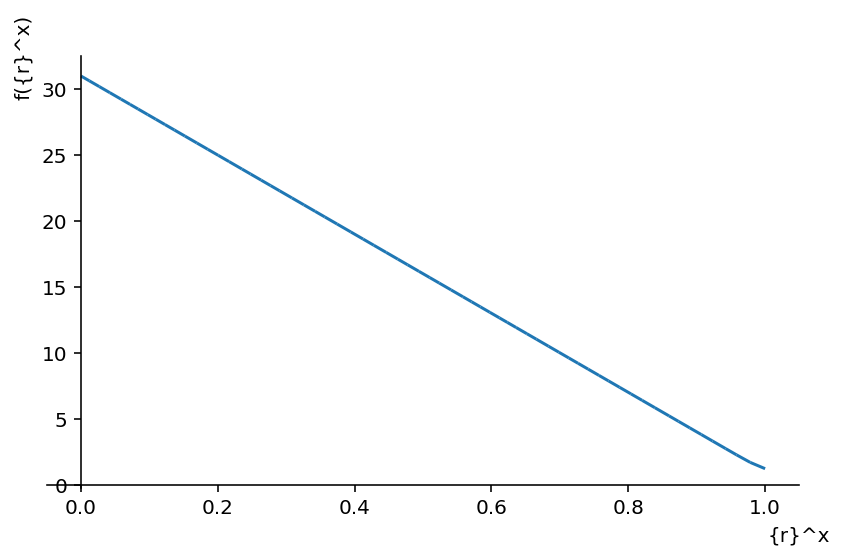

In [29]:
sy.plot(gmeq.varphi_model_rampflat_eqn.rhs.subs(sub), (rx,0,1));

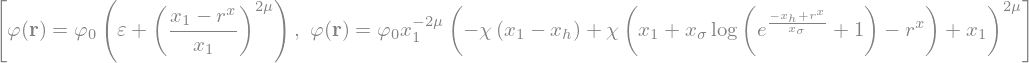

In [30]:
eqns(['varphi_model_ramp_eqn','varphi_model_rampflatmu_eqn'])

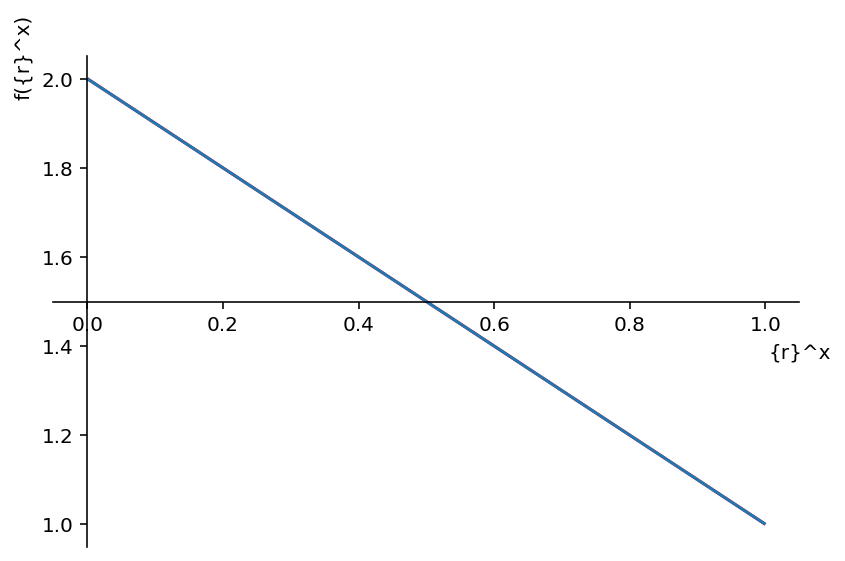

In [31]:
p = sy.plot(gmeq.varphi_model_ramp_eqn.rhs.subs({varphi_0:1, varepsilon:1, x_1:1, mu:Rational(1,2)}),
 gmeq.varphi_model_ramp_eqn.rhs.subs({varphi_0:1, varepsilon:1, x_1:1, mu:Rational(1,2)}), 
        (rx,0,1), show=False);
p[0].line_color = 'red'
p.show()

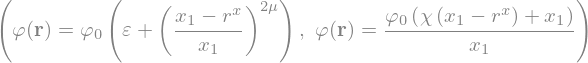

In [32]:
gmeq.varphi_model_ramp_eqn.subs({x_sigma:0}), \
    simplify(gmeq.varphi_model_rampflat_eqn.subs({x_sigma:0}))

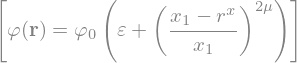

In [33]:
eqns(['varphi_rx_eqn'])

### $\varphi$ related eqns

In [34]:
gmeq.define_varphi_related_eqns()

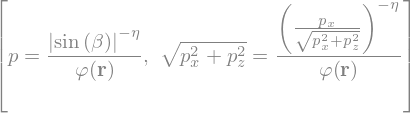

In [35]:
eqns(['p_varphi_beta_eqn', 'p_varphi_pxpz_eqn'])

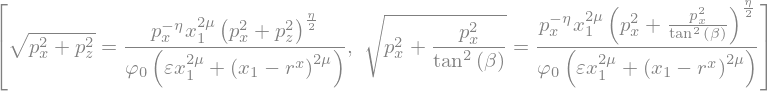

In [36]:
eqns(['p_rx_pxpz_eqn', 'p_rx_tanbeta_eqn'])

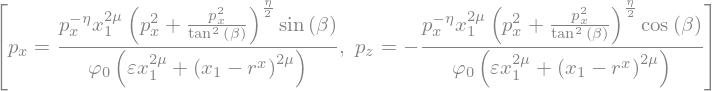

In [37]:
eqns(['px_beta_eqn', 'pz_beta_eqn'])

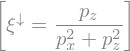

In [38]:
eqns(['xiv_pxpz_eqn'])

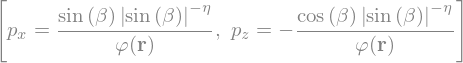

In [39]:
eqns(['px_varphi_beta_eqn', 'pz_varphi_beta_eqn'])

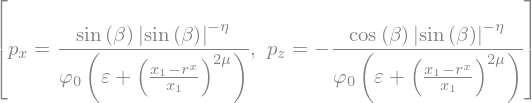

In [40]:
eqns(['px_varphi_rx_beta_eqn','pz_varphi_rx_beta_eqn'])

### $p_x$ polynomial

This polynomial in $p_x$, or in $\tan\beta=-p_x/p_z=-p_x\xi^{\downarrow 0}$, is a polynomial in gradient $dz/dx$, which means (if it can be solved for) it can be integrated to give $z(x)$.

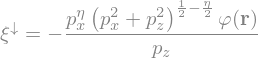

In [41]:
gmeq.xiv_varphi_pxpz_eqn

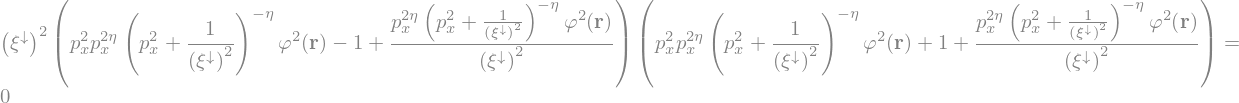

In [42]:
gmeq.px_xiv_varphi_eqn

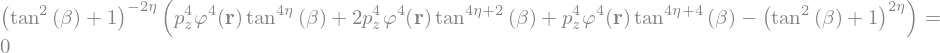

In [43]:
p0 = Eq( (simplify(expand(gmeq.px_xiv_varphi_eqn.lhs/xiv**2).subs({px:-pz*tan(beta), xiv:-1/pz})) 
    .subs({cos(beta):1/sqrt(1+tan(beta)**2)})), 0)
p0

In [44]:
p_eta1p5 = Eq( numer(factor(p0.lhs.subs({eta:gmeq.eta}))), 0)
p_eta1p5

In [45]:
gmeq.define_px_poly_eqn(eta_choice=gmeq.eta)

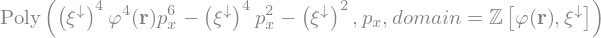

In [46]:
gmeq.poly_px_xiv_varphi_eqn

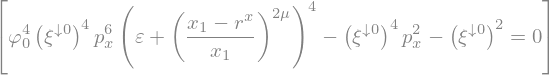

In [47]:
eqns(['poly_px_xiv0_eqn'])

In [48]:
# gmeq.define_px_poly_eqn(eta_choice=Rational(3,2))

In [49]:
# gmeq.poly_px_xiv_varphi_eqn

In [50]:
# eqns(['poly_px_xiv0_eqn'])

## Fundamental function & Hamiltonian

In [51]:
gmeq.define_Fstar_eqns()
gmeq.define_H_eqns()

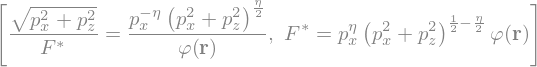

In [52]:
eqns(['Okubo_Fstar_eqn', 'Fstar_eqn'])

$
    H := \dfrac{\varphi^2 p_x^{2\eta}}{2\left(p_x^2+p_z^2\right)^{\eta-1}}
$

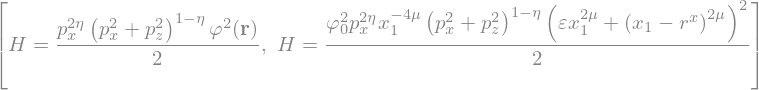

In [53]:
eqns(['H_eqn', 'H_varphi_rx_eqn'])

## Ray tracing (Hamilton's equations)

ODE $\dot{\mathbf{r}}$ components

In [54]:
gmeq.define_rdot_eqns()

In [55]:
eqns(['rdotx_rdot_alpha_eqn', 'rdotz_rdot_alpha_eqn'])

Derivation of $v^z$ gives zero if the Hamiltonian has no dependence on $p_z$, which happens if the angle function is $\sin\beta$ and if its exponent is $\eta=1$. From this point on, such a model fails.

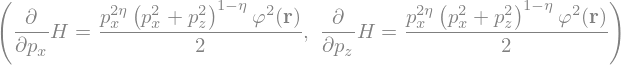

In [56]:
simplify( sy.diff(gmeq.H_eqn,px) ), simplify( sy.diff(gmeq.H_eqn,pz) )

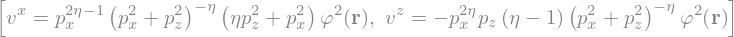

In [57]:
eqns(['rdotx_pxpz_eqn', 'rdotz_pxpz_eqn'])

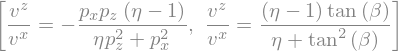

In [58]:
eqns(['rdotz_on_rdotx_eqn', 'rdotz_on_rdotx_tanbeta_eqn'])

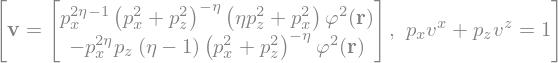

In [59]:
eqns(['rdot_vec_eqn', 'rdot_p_unity_eqn'])

ODE $\dot{\mathbf{\widetilde{p}}}$ components

In [60]:
gmeq.define_pdot_eqns()

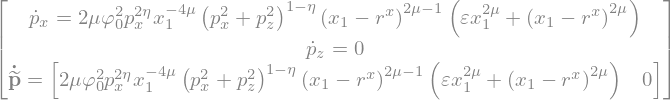

In [61]:
Matrix(eqns(['pdotx_pxpz_eqn', 'pdotz_pxpz_eqn', 'pdot_covec_eqn']))

Combined ODE components

In [62]:
gmeq.define_Hamiltons_eqns()

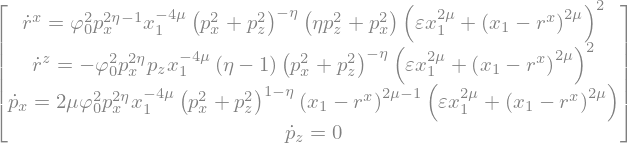

In [63]:
gmeq.hamiltons_eqns #, gmeq.hamiltons_eqns.subs({zeta:gmeq.zeta})

## Angles

### $\tan\alpha$

In [64]:
gmeq.define_tanalpha_eqns()

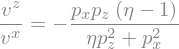

In [65]:
gmeq.rdotz_on_rdotx_eqn

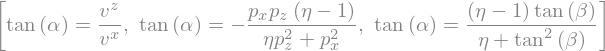

In [66]:
eqns(['tanalpha_rdot_eqn', 'tanalpha_pxpz_eqn', 'tanalpha_beta_eqn'])

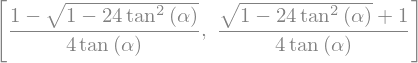

In [67]:
solve( simplify( gmeq.tanalpha_beta_eqn.subs({eta:gmeq.eta}) ), tan(beta) )

### $\tan\beta_c$, $\tan\alpha_c$

In [68]:
gmeq.define_tanbeta_eqns()

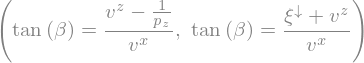

In [69]:
gmeq.tanbeta_rdotxz_pz_eqn, gmeq.tanbeta_rdotxz_xiv_eqn

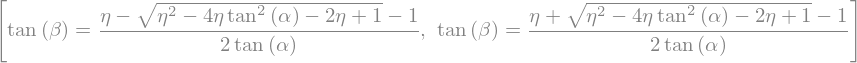

In [70]:
gmeq.tanbeta_alpha_eqns

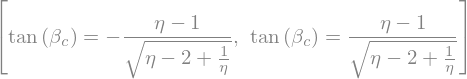

In [71]:
gmeq.tanbeta_crit_eqns

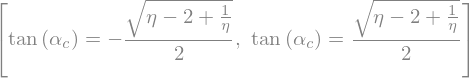

In [72]:
gmeq.tanalpha_crit_eqns

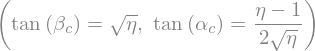

In [73]:
gmeq.tanbeta_crit_eqn, gmeq.tanalpha_crit_eqn

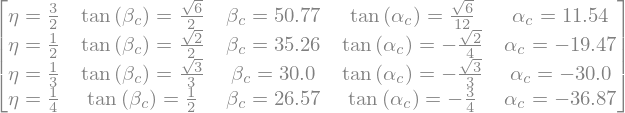

In [74]:
Matrix([(  Eq(eta,eta_), 
           gmeq.tanbeta_crit_eqn.subs({eta:eta_}),
           Eq(beta_crit, round(N(deg(atan(gmeq.tanbeta_crit_eqn.rhs.subs({eta:eta_})))),2)),
           gmeq.tanalpha_crit_eqn.subs({eta:eta_}),
           Eq(alpha_crit, round(N(deg(atan(gmeq.tanalpha_crit_eqn.rhs.subs({eta:eta_})))),2)) )
 for eta_ in [Rational(3,2),Rational(1,2),Rational(1,3),Rational(1,4)]])

## Metric tensor

In [75]:
gmeq.define_g_eqns()

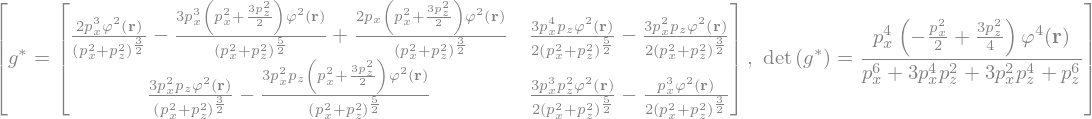

In [76]:
eqns(['gstar_varphi_pxpz_eqn', 'det_gstar_varphi_pxpz_eqn'])

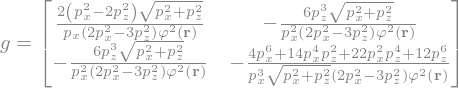

In [77]:
gmeq.g_varphi_pxpz_eqn

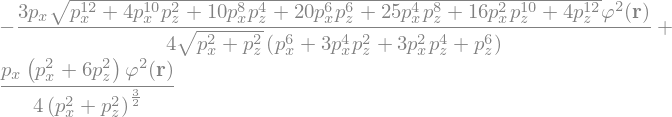

In [78]:
gmeq.gstar_eigen_varphi_pxpz[0][0] if gmeq.gstar_eigen_varphi_pxpz is not None \
                                    else None

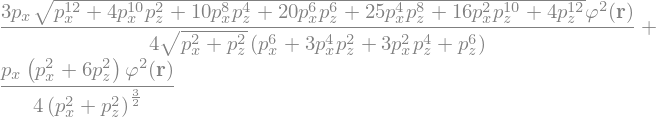

In [79]:
gmeq.gstar_eigen_varphi_pxpz[1][0] if gmeq.gstar_eigen_varphi_pxpz is not None \
                                    else None

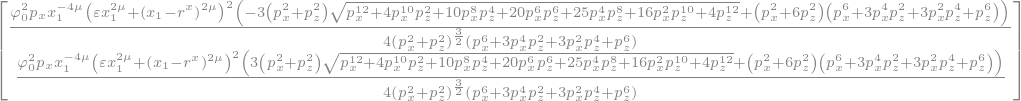

In [80]:
gmeq.gstar_eigenvalues

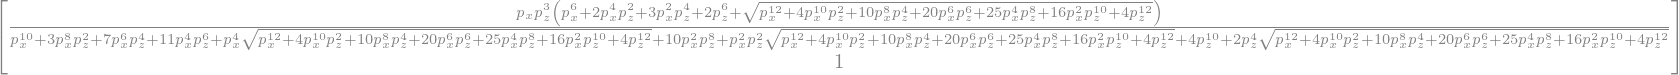

In [81]:
gmeq.gstar_eigenvectors[0] if gmeq.gstar_eigenvectors is not None else None

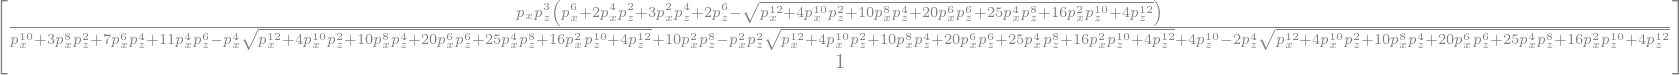

In [82]:
gmeq.gstar_eigenvectors[1] if gmeq.gstar_eigenvectors is not None else None

## Indicatrix & figuratrix

In [83]:
gmeq.define_idtx_fgtx_eqns()

Closed-form solutions for the indicatrix & figuratrix can be found if the following is solvable in $\cos^2\beta$:

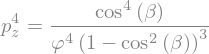

In [84]:
gmeq.pz_cosbeta_varphi_eqn if gmeq.pz_cosbeta_varphi_eqn is not None else None

In [85]:
expand( Eq( gmeq.pz_cosbeta_varphi_eqn.lhs*denom(gmeq.pz_cosbeta_varphi_eqn.rhs)
               -numer(gmeq.pz_cosbeta_varphi_eqn.rhs),0 ) )

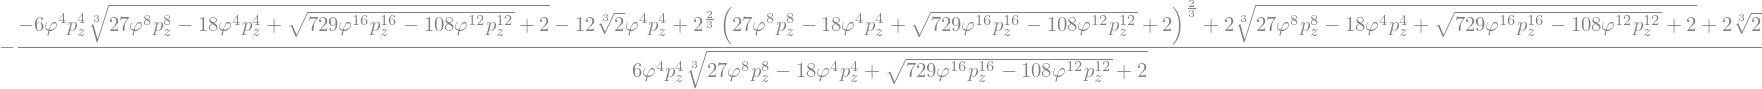

In [86]:
factor( gmeq.cosbetasqrd_pz_varphi_solns[0] ) \
    if gmeq.cosbetasqrd_pz_varphi_solns is not None else None

In [87]:
# cosbetasqrd_pz_varphi_solns = solve( gmeq.pz_cosbeta_varphi_eqn, cos(beta)**2 )
# cosbetasqrd_pz_varphi_solns

In [88]:
# N( cosbetasqrd_pz_varphi_solns[0].subs({varphi:10,pz:-0.1}) )

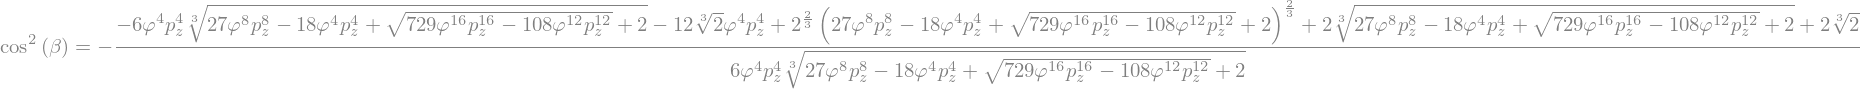

In [89]:
factor( gmeq.fgtx_cossqrdbeta_pz_varphi_eqn ) \
    if gmeq.fgtx_cossqrdbeta_pz_varphi_eqn is not None else None

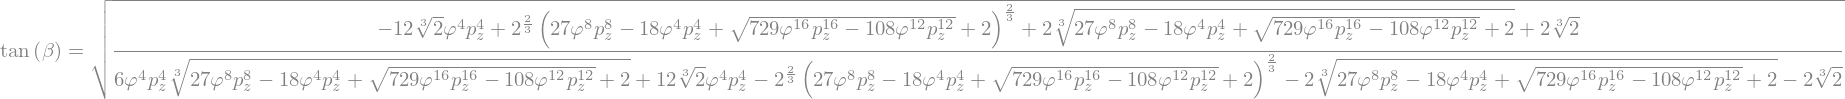

In [90]:
factor( gmeq.fgtx_tanbeta_pz_varphi_eqn  )\
    if gmeq.fgtx_tanbeta_pz_varphi_eqn is not None else None

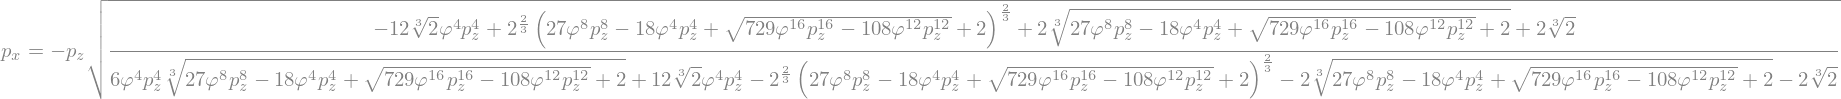

In [91]:
gmeq.fgtx_px_pz_varphi_eqn if gmeq.fgtx_px_pz_varphi_eqn is not None else None

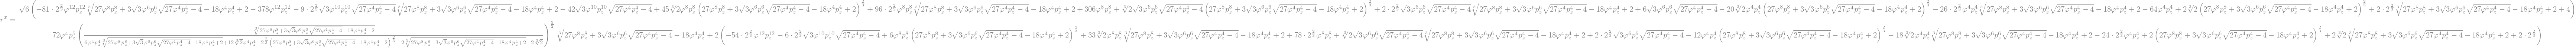

In [92]:
factor( gmeq.idtx_rdotx_pz_varphi_eqn ) if gmeq.idtx_rdotx_pz_varphi_eqn is not None \
                              else None

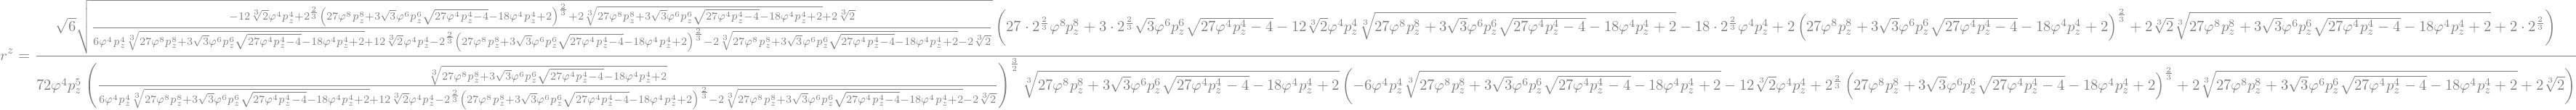

In [93]:
gmeq.idtx_rdotz_pz_varphi_eqn if gmeq.idtx_rdotz_pz_varphi_eqn is not None \
                              else None

## Geodesic equations

### Preamble

In [94]:
gmeq.prep_geodesic_eqns(parameters=sub)

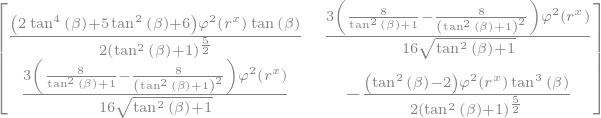

In [95]:
gmeq.gstar_ij_tanbeta_mat if gmeq.gstar_ij_tanbeta_mat is not None else None

In [96]:
gmeq.tanbeta_poly_eqn

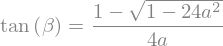

In [97]:
gmeq.tanbeta_eqn

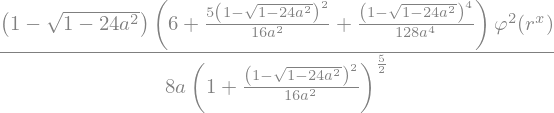

In [98]:
gmeq.gstar_ij_tanalpha_mat[0] if gmeq.gstar_ij_tanalpha_mat is not None else None

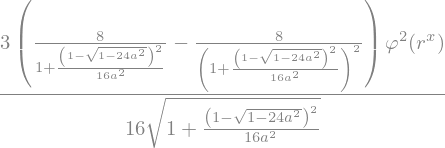

In [99]:
gmeq.gstar_ij_tanalpha_mat[1] if gmeq.gstar_ij_tanalpha_mat is not None else None

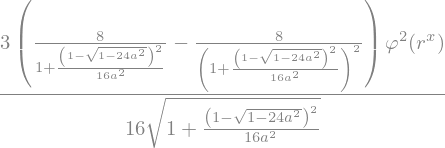

In [100]:
gmeq.gstar_ij_tanalpha_mat[2] if gmeq.gstar_ij_tanalpha_mat is not None else None

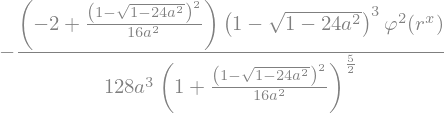

In [101]:
gmeq.gstar_ij_tanalpha_mat[3] if gmeq.gstar_ij_tanalpha_mat is not None else None

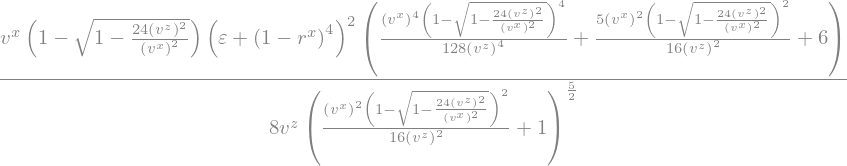

In [102]:
gmeq.gstar_ij_mat[0] if gmeq.gstar_ij_mat is not None else None

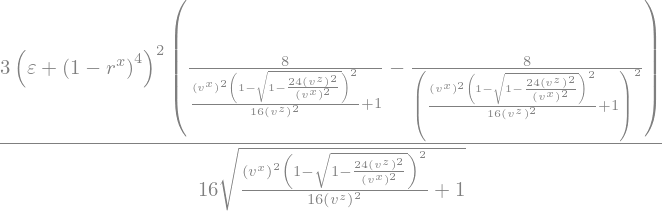

In [103]:
gmeq.gstar_ij_mat[1] if gmeq.gstar_ij_mat is not None else None

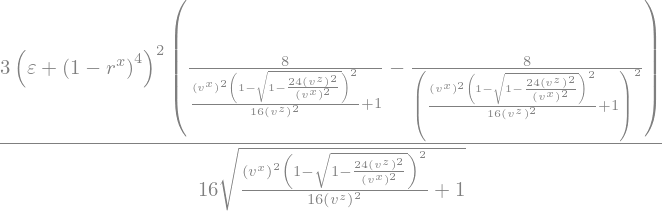

In [104]:
gmeq.gstar_ij_mat[2] if gmeq.gstar_ij_mat is not None else None

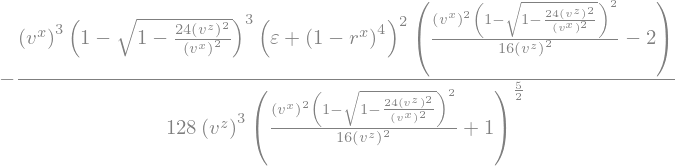

In [105]:
gmeq.gstar_ij_mat[3] if gmeq.gstar_ij_mat is not None else None

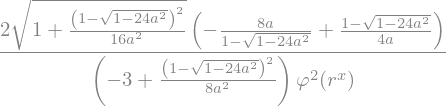

In [106]:
gmeq.g_ij_tanalpha_mat[0] if gmeq.g_ij_tanalpha_mat is not None else None

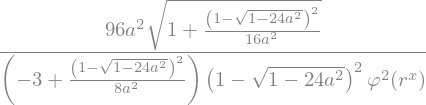

In [107]:
gmeq.g_ij_tanalpha_mat[1] if gmeq.g_ij_tanalpha_mat is not None else None

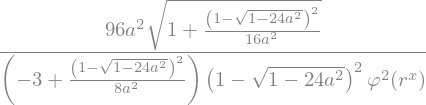

In [108]:
gmeq.g_ij_tanalpha_mat[2] if gmeq.g_ij_tanalpha_mat is not None else None

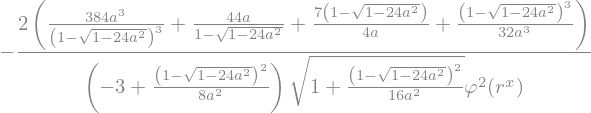

In [109]:
gmeq.g_ij_tanalpha_mat[3] if gmeq.g_ij_tanalpha_mat is not None else None

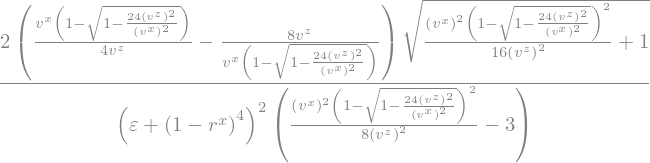

In [110]:
gmeq.g_ij_mat[0] if gmeq.g_ij_mat is not None else None

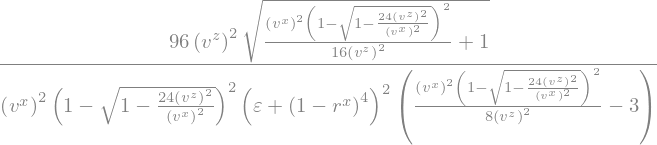

In [111]:
gmeq.g_ij_mat[1] if gmeq.g_ij_mat is not None else None

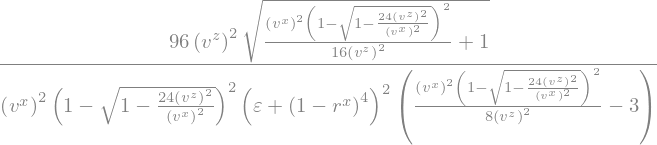

In [112]:
gmeq.g_ij_mat[2] if gmeq.g_ij_mat is not None else None

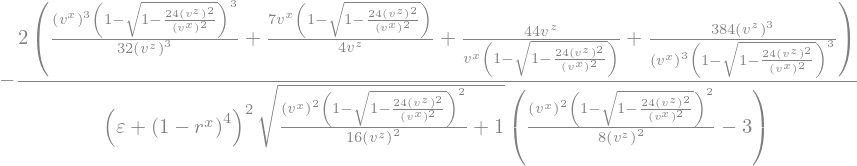

In [113]:
gmeq.g_ij_mat[3] if gmeq.g_ij_mat is not None else None

### Main

In [114]:
gmeq.define_geodesic_eqns(parameters=sub)

In [115]:
gmeq.geodesic_eqns[0:2] if gmeq.geodesic_eqns is not None else None

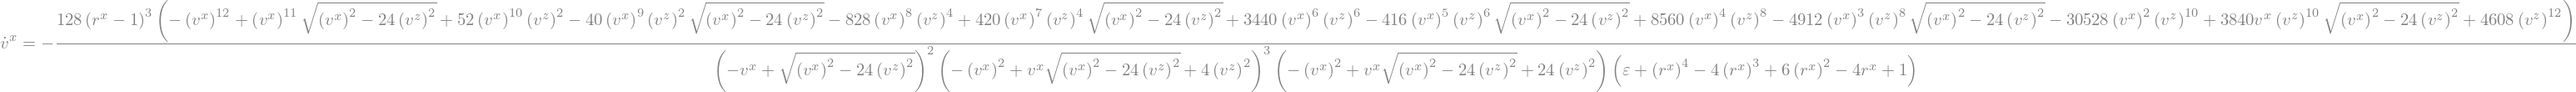

In [116]:
factor(gmeq.geodesic_eqns[2]) if gmeq.geodesic_eqns is not None else None

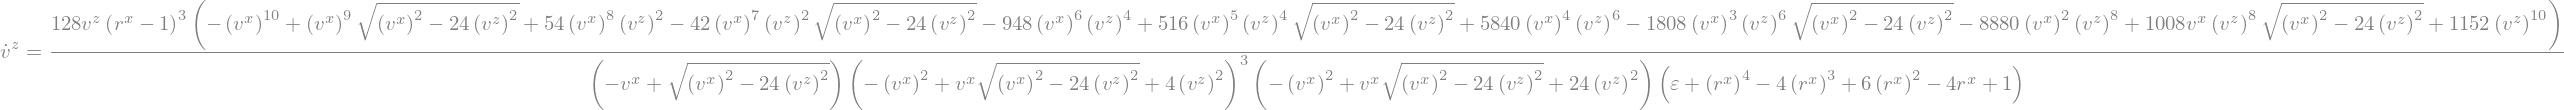

In [117]:
factor(gmeq.geodesic_eqns[3]) if gmeq.geodesic_eqns is not None else None

## Initial conditions

In [118]:
gmeq.prep_ibc_eqns()

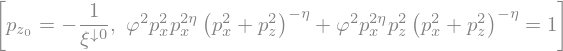

In [119]:
eqns(['pz0_xiv0_eqn','pzpx_unity_eqn'])

In [120]:
gmeq.define_ibc_eqns()

In [121]:
[[key for key in gmeq.boundary_eqns[bc_type].keys()]
   for bc_type in gmeq.boundary_eqns.keys()]

[['h', 'gradh'], ['h', 'gradh'], ['h', 'gradh']]

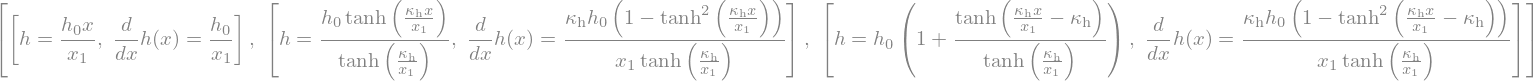

In [122]:
[[value for value in gmeq.boundary_eqns[bc_type].values()]
  for bc_type in gmeq.boundary_eqns.keys()]

In [123]:
gmeq.set_ibc_eqns()

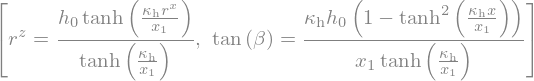

In [124]:
eqns(['rz_initial_eqn','tanbeta_initial_eqn'])

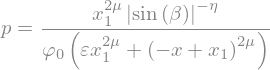

In [125]:
gmeq.p_initial_eqn

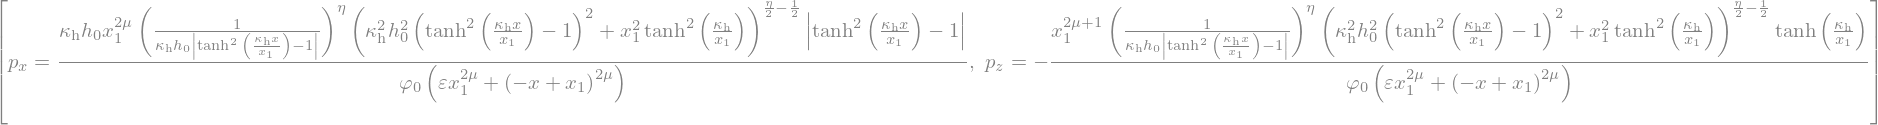

In [126]:
eqns(['px_initial_eqn','pz_initial_eqn'])